# Survey of fuel prices in Brazil / Geospatial Analysis

#### Background
Time series analysis of fuel prices by geographic region in Brazil. This dataset was made available through [Kaggle](https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil) from the [Agência Nacional do Petróleo, Gás Natural e Biocombustíveis](http://www.anp.gov.br/precos-e-defesa-da-concorrencia/precos/levantamento-de-precos/serie-historica-do-levantamento-de-precos-e-de-margens-de-comercializacao-de-combustiveis) and comprises weekly reports of gas, diesel and other fuel prices used in different parts of Brazil.

#### Structure
This analysis consists of 2 notebooks:
* *0.1-import-clean-eda* - Import & Cleaning, Exploratory Data Analysis
* *0.2-geospatial-analysis* - Geospatial Analysis

#### Questions
The geospatial analysis seeks to answer the 3 questions on the Kaggle website:
1. How did gas prices change in different regions of Brazil?
2. Within a region, which states increased their prices?
3. Which states are the cheapest (or most expensive) for different types of fuels?


## 1. Import Data

In [17]:
import os
import sys
sys.path[0] = '../'

# Import libraries
from IPython.display import display, HTML # Display functions
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("colorblind") 
sns.set_style("whitegrid")
fig_path = sys.path[0] + 'figures/' # path for saving figures

# Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import geospaitial libraries
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import adjustText as aT

In [2]:
# Read data
path = '../data/processed/fuel_in_brazil_clean.csv'

df = pd.read_csv(path, parse_dates=True)
df.head()

,Analysis_Date,Macroregion,State,Product,No_of_Gas_Stations_Analyzed,Measurement_unit,Mean_Price,Std_Dev,Min_Price,Max_Price,Mean_Price_Margin,Coefficient_of_variation,Mean_Dist_Price,Dist_Std_Dev,Dist_Min_Price,Dist_Max_Price,Dist_Coefficient_of_Variation,Month,Year,Price_Group,Mean_Price_Norm,Year_Month
0,2004-05-09,CENTRO OESTE,DISTRITO FEDERAL,HYDROUS ETHANOL,127,liter,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.110,0.4201,0.96660,0.133,5,2004,1,0.141348,2004-05-01
1,2004-05-09,CENTRO OESTE,GOIAS,HYDROUS ETHANOL,387,liter,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05000,0.115,5,2004,1,0.107230,2004-05-01
2,2004-05-09,CENTRO OESTE,MATO GROSSO,HYDROUS ETHANOL,192,liter,1.389,0.097,1.18,1.760,0.419,0.070,0.970,0.095,0.5614,1.16100,0.098,5,2004,1,0.168698,2004-05-01
3,2004-05-09,CENTRO OESTE,MATO GROSSO DO SUL,HYDROUS ETHANOL,162,liter,1.262,0.070,1.09,1.509,0.432,0.055,0.830,0.119,0.5991,1.22242,0.143,5,2004,1,0.134308,2004-05-01
4,2004-05-09,NORDESTE,ALAGOAS,HYDROUS ETHANOL,103,liter,1.181,0.078,1.05,1.400,0.240,0.066,0.941,0.077,0.7441,1.03170,0.082,5,2004,1,0.112375,2004-05-01


## 2. Geospatial Analysis

The geospatial analysis seeks to answer the 3 questions on the [Kaggle](https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil) website:
1. How did gas prices change in different regions of Brazil?
2. Within a region, which states increased their prices?
3. Which states are the cheapest (or most expensive) for different types of fuels?

To answer these questions we will 1) include geographical shape files of Brazil's states and 2) create a new dataframe containing the percent change in prices.

In [3]:
df.head()

,Analysis_Date,Macroregion,State,Product,No_of_Gas_Stations_Analyzed,Measurement_unit,Mean_Price,Std_Dev,Min_Price,Max_Price,Mean_Price_Margin,Coefficient_of_variation,Mean_Dist_Price,Dist_Std_Dev,Dist_Min_Price,Dist_Max_Price,Dist_Coefficient_of_Variation,Month,Year,Price_Group,Mean_Price_Norm,Year_Month
0,2004-05-09,CENTRO OESTE,DISTRITO FEDERAL,HYDROUS ETHANOL,127,liter,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.110,0.4201,0.96660,0.133,5,2004,1,0.141348,2004-05-01
1,2004-05-09,CENTRO OESTE,GOIAS,HYDROUS ETHANOL,387,liter,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05000,0.115,5,2004,1,0.107230,2004-05-01
2,2004-05-09,CENTRO OESTE,MATO GROSSO,HYDROUS ETHANOL,192,liter,1.389,0.097,1.18,1.760,0.419,0.070,0.970,0.095,0.5614,1.16100,0.098,5,2004,1,0.168698,2004-05-01
3,2004-05-09,CENTRO OESTE,MATO GROSSO DO SUL,HYDROUS ETHANOL,162,liter,1.262,0.070,1.09,1.509,0.432,0.055,0.830,0.119,0.5991,1.22242,0.143,5,2004,1,0.134308,2004-05-01
4,2004-05-09,NORDESTE,ALAGOAS,HYDROUS ETHANOL,103,liter,1.181,0.078,1.05,1.400,0.240,0.066,0.941,0.077,0.7441,1.03170,0.082,5,2004,1,0.112375,2004-05-01


### 2.1 Import geometry

In [4]:
# URL to shape files of Brazil's states, made public courtesy of the Brazilian government
#url = "ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2016/Brasil/BR/br_unidades_da_federacao.zip"

url= '../data/external/br_unidades_da_federacao/'

brazil_geo = gpd.read_file(url)

# Correct state names to match current dataset
state_dict = {"RONDÔNIA":"RONDONIA", "PARÁ":"PARA", "AMAPÁ":"AMAPA", "MARANHÃO":"MARANHAO",
             "PIAUÍ":"PIAUI", "CEARÁ":"CEARA", "PARAÍBA":"PARAIBA", "ESPÍRITO SANTO":"ESPIRITO SANTO",
             "SÃO PAULO":"SAO PAULO", "PARANÁ":"PARANA", "GOIÁS":"GOIAS", "ACRE":"ACRE",
             "AMAZONAS":"AMAZONAS", "RORAIMA":"RORAIMA", "TOCANTINS":"TOCANTINS", 
             "RIO GRANDE DO NORTE":"RIO GRANDE DO NORTE", "PERNAMBUCO":"PERNAMBUCO", 
             "ALAGOAS":"ALAGOAS", "SERGIPE":"SERGIPE", "BAHIA":"BAHIA", "MINAS GERAIS":"MINAS GERAIS",
             "RIO DE JANEIRO":"RIO DE JANEIRO", "SANTA CATARINA":"SANTA CATARINA", "MATO GROSSO DO SUL":"MATO GROSSO DO SUL", 
             "MATO GROSSO":"MATO GROSSO", "DISTRITO FEDERAL":"DISTRITO FEDERAL", "RIO GRANDE DO SUL":"RIO GRANDE DO SUL"}

brazil_geo["NM_ESTADO"] = brazil_geo.NM_ESTADO.map(state_dict)

brazil_geo.crs = {"init": "epsg:4326"}

brazil_geo.columns = ['State', 'Macroregion', 'CD_GEOCUF', 'geometry']

brazil_geo["Macroregion"] = brazil_geo.Macroregion.str.replace("-", " ")

# Extract regions geography
brazil_geo_region = brazil_geo.dissolve(by='Macroregion').reset_index()
brazil_geo_region = brazil_geo_region[['Macroregion', 'geometry']]

/Users/gregory/anaconda3/envs/brazil_fuel_price_env2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### 2.2 Reference Map of Brazil

In [5]:
macroregions_geo = brazil_geo_region[['Macroregion', 'geometry']].drop_duplicates()
states_geo = brazil_geo[['State', 'geometry']].drop_duplicates()

In [6]:
def create_ref_map(data, column, fontsize=12):
    
    #data['coords'] = data['geometry'].apply(lambda x: x.centroid)
    #data_points.set_geometry('coords', inplace = True)
    
    data['coords'] = data['geometry'].apply(lambda x: x.centroid)
    data_points = data.copy()
    data_points.set_geometry('coords', inplace = True)
    
    ax = data.plot(figsize=(10, 8), color="lightgrey", edgecolor="grey", linewidth=0.5)

    texts = []

    for x, y, label in zip(data_points.geometry.x, data_points.geometry.y, data_points[column]):
        texts.append(plt.text(x, y, label, fontsize=fontsize))   

    aT.adjust_text(texts, force_points=0.0, force_text=0.1, expand_points=(1,1), expand_text=(1,1), 
                   arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

    return ax

#### 2.2.1 Macroregions Reference Map

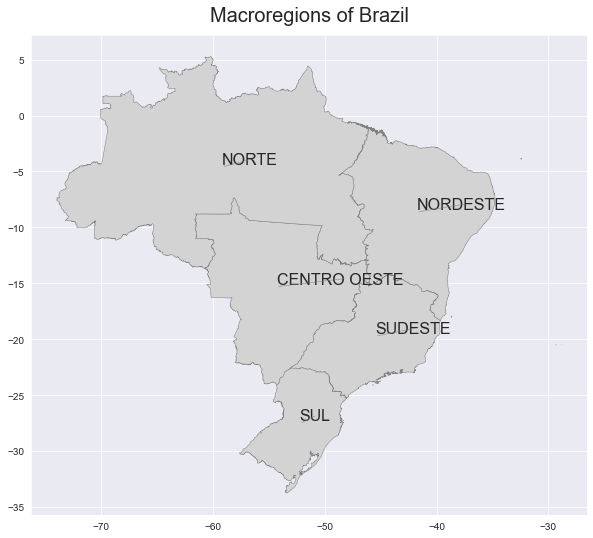

In [7]:
create_ref_map(macroregions_geo, 'Macroregion', fontsize=16);
plt.suptitle("Macroregions of Brazil", fontsize=20)
plt.tight_layout(pad=4)
plt.savefig(fig_path + 'map_brazil_macroregions.png', bbox_inches='tight')
plt.show()

#### 2.2.2 States Reference Map

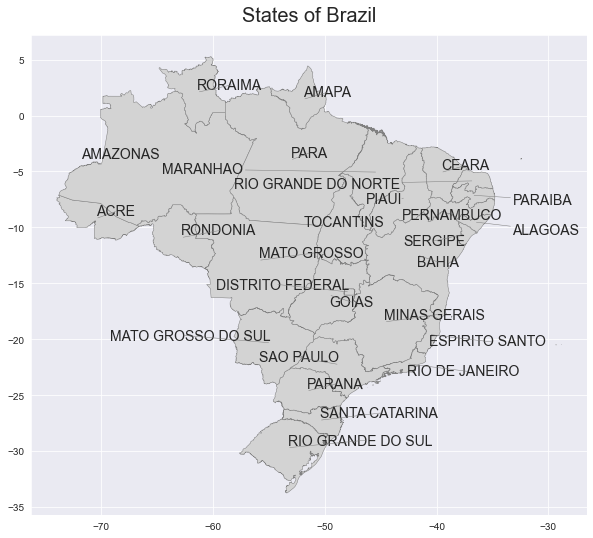

In [8]:
create_ref_map(states_geo, 'State', fontsize=14);
plt.suptitle("States of Brazil", fontsize=20)
plt.tight_layout(pad=4)
plt.savefig(fig_path + 'map_brazil_states.png', bbox_inches='tight')
plt.show()

### 2.3 Percent Change in Price Data

Percentage price change must be calculated and included as it's own dataframe.

#### 2.3.1 Calculate Percentage Change Price

In [9]:
# Create dataframe df_pct_change with percent change of prices
macroregions = df.Macroregion.unique().tolist()

df_pct_change = pd.DataFrame()

count = 0

for i in range(len(macroregions)):
    region = macroregions[i]
    states = df[df.Macroregion==region]["State"].unique()
    
    for i in range(len(states)):
        state = states[i]
        products = df[(df.Macroregion==region) & (df.State==state)]["Product"].unique()
       
        for i in range(len(products)):
            product = products[i]
            years = df[(df.Macroregion==region) & (df.State==state) & (df.Product==product)]["Year"].unique()
            
            mean_price = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product)]["Mean_Price"].mean()
            
            # Percent change for raw data
            first_price = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[0])]["Mean_Price"].iloc[0]
            last_price = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[-1])]["Mean_Price"].iloc[-1]
            price_pct_change = (last_price - first_price) / np.abs(first_price)
        
        
            # Percent change for Normalized data
            first_price_norm = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[0])]["Mean_Price_Norm"].iloc[0]
            last_price_norm = df[(df.Macroregion==region) & (df.State==state) & 
                            (df.Product==product) & (df.Year==years[-1])]["Mean_Price_Norm"].iloc[-1]
            price_pct_change_norm = (last_price_norm - first_price_norm) / np.abs(first_price_norm)            
            
            # Add to dataframe
            df_temp = pd.DataFrame({"Macroregion":region, "State":state, 
                                    "Product":product, 
                                    "First_Year":years[0], "Last_Year":years[-1], "Fuel_Mean_Price":mean_price,
                                    "First_Price":first_price, "Last_Price":last_price, "Price_Pct_Change":price_pct_change, 
                                    "First_Price_Norm":first_price_norm, "Last_Price_Norm":last_price_norm, 
                                    "Price_Pct_Change_Norm":price_pct_change_norm
                                   }, 
                                   index=[count])
            
            df_pct_change = df_pct_change.append(df_temp)
            
            count += 1

<ipython-input-9-fdfd76156a6b>:36: RuntimeWarning: divide by zero encountered in double_scalars
  price_pct_change_norm = (last_price_norm - first_price_norm) / np.abs(first_price_norm)


#### 2.3.2 Merging Percentage Change Price with Geographic Data

In [10]:
# Group by percentage change by macroregion
df_pct_change_region = df_pct_change.groupby(['Macroregion', 'Product']).mean().reset_index()

# Merge new datasets with spatial data
brazil_geo = brazil_geo.drop('Macroregion', axis=1).merge(df_pct_change, on='State')
brazil_geo_region = brazil_geo_region.merge(df_pct_change_region, on='Macroregion')

# Correct datatypes
for col in ['First_Year', 'Last_Year']:
    brazil_geo_region[col] = brazil_geo_region[col].astype(int)

## 3. Questions

### 3.1 How did gas prices change in different regions of Brazil?

To investigate the question of how price changed by region we will create a choropleth map varying by the percentage change in price for each fuel for the entire time data is available.

#### Choropleth: Mean Price Percentage Change by Region

The choropleth provides an easy idea to how prices have changed for different fuel products in Brazil.

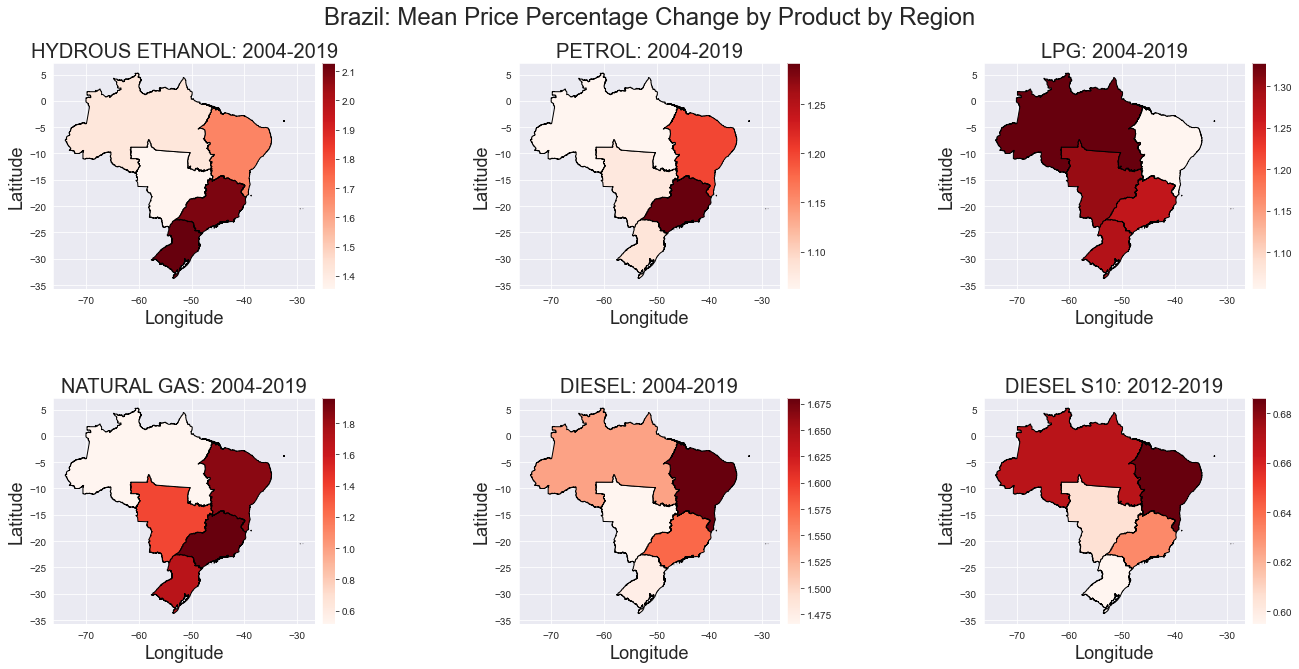

In [11]:
# Create plot with raw price data: choropleth_product(data, column, title, cmap)
nrows = 2
ncols = 3
products = df.Product.unique().tolist()

fig_raw, ax_raw = plt.subplots(figsize=(20,10), nrows=nrows, ncols=ncols)

n = 0

for row in range(nrows):
   
    for col in range(ncols):
        
        divider = make_axes_locatable(ax_raw[row,col])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        brazil_geo_region[brazil_geo_region.Product==products[n]].plot(column="Price_Pct_Change", 
                                                                       legend=True, ax=ax_raw[row,col], cmap="Reds", 
                                                                       cax=cax, edgecolor='black')
        
        # Plot titles
        year_range = brazil_geo_region[brazil_geo_region.Product==products[n]][["First_Year", "Last_Year"]]
        year_range = [year_range["First_Year"].min(), year_range["Last_Year"].max()]
        year_range = str(year_range[0]) + "-" + str(year_range[1])
        
        ax_raw[row,col].set_title(products[n] + ": " + year_range, fontsize=20)
        ax_raw[row,col].set_xlabel("Longitude", fontsize=18)
        ax_raw[row,col].set_ylabel("Latitude", fontsize=18)
        n += 1

fig_raw.suptitle("Brazil: Mean Price Percentage Change by Product by Region", fontsize=24)
plt.tight_layout(pad=5)
plt.savefig(fig_path + 'choropleth_mean_price_pct_change_region.png', bbox_inches='tight')
plt.show()

#### Discussion

These maps provide an overview enough to give an idea to the answer to the questions. An in-depth quantitive analysis could provide a numerical answer. It is important to keep in mind however that the colors of one map should not be compared with those of another map because of the difference in scale: each specific color on a map represents a value unique to that map. If the products were mapped using the same scale, some colors might not be different enough to show any useful change in quantity.

### 3.2 Within a region, which states increased their prices the most?

Create a new dataframe to show percent change during the period data was collected:

#### Choropleth: Mean Price Percentage Change by Product by State

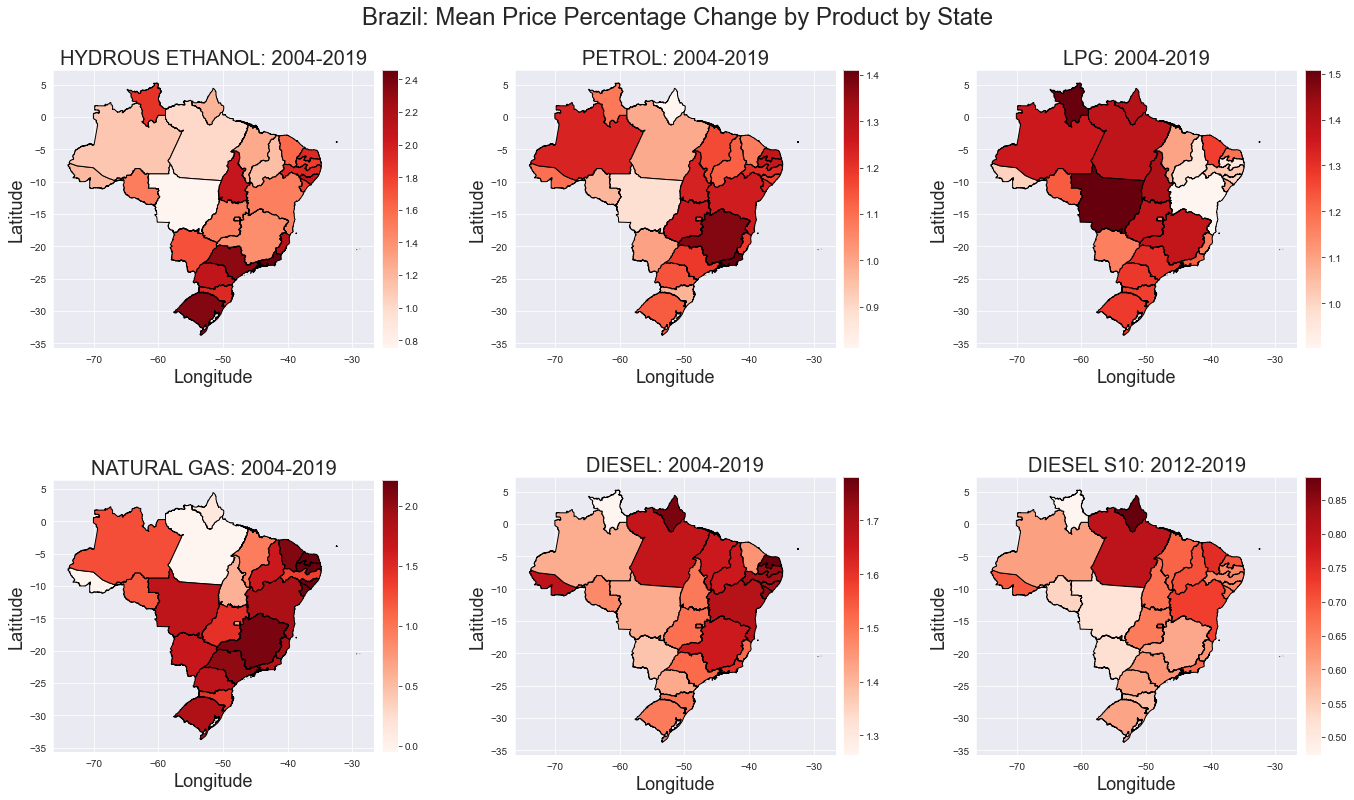

In [12]:
# Create plot function with raw price data: choropleth_product(data, column, title, cmap)
nrows = 2
ncols = 3
products = df.Product.unique().tolist()

fig_raw, ax_raw = plt.subplots(figsize=(20,12), nrows=nrows, ncols=ncols)

n = 0

for row in range(nrows):
   
    for col in range(ncols):
        
        divider = make_axes_locatable(ax_raw[row,col])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        brazil_geo[brazil_geo.Product==products[n]].plot(column="Price_Pct_Change", 
                                                                       legend=True, ax=ax_raw[row,col], cmap="Reds", 
                                                                       cax=cax, edgecolor='black')
        
        # Plot titles
        year_range = brazil_geo[brazil_geo.Product==products[n]][["First_Year", "Last_Year"]]
        year_range = [year_range["First_Year"].min(), year_range["Last_Year"].max()]
        year_range = str(year_range[0]) + "-" + str(year_range[1])
        
        ax_raw[row,col].set_title(products[n] + ": " + year_range, fontsize=20)
        ax_raw[row,col].set_xlabel("Longitude", fontsize=18)
        ax_raw[row,col].set_ylabel("Latitude", fontsize=18)
        n += 1

fig_raw.suptitle("Brazil: Mean Price Percentage Change by Product by State", fontsize=24)
plt.tight_layout(pad=5)
plt.savefig(fig_path + 'choropleth_mean_price_pct_change_state', bbox_inches='tight')
plt.show()

#### Discussion

It is interesting to see how prices have changed in each state for the years indicated in the data. Making any concrete comparisons should rely on a quantitative analysis of price differences, but for the purpose of exploring the data the choropleths give a quick idea as to the price behavior.

### 3.3 Which states are the cheapest (or most expensive) for different types of fuels?

#### Choropleth: Mean Price of Fuels by State

In [13]:
# Group by State and Product
brazil_fuel_state = brazil_geo.groupby(["State", "Product"])["Fuel_Mean_Price"].mean().reset_index()

# Rejoin with spatial data
brazil_fuel_state_geo = brazil_geo.merge(brazil_fuel_state.drop(['Product','Fuel_Mean_Price'], axis=1) , on="State")

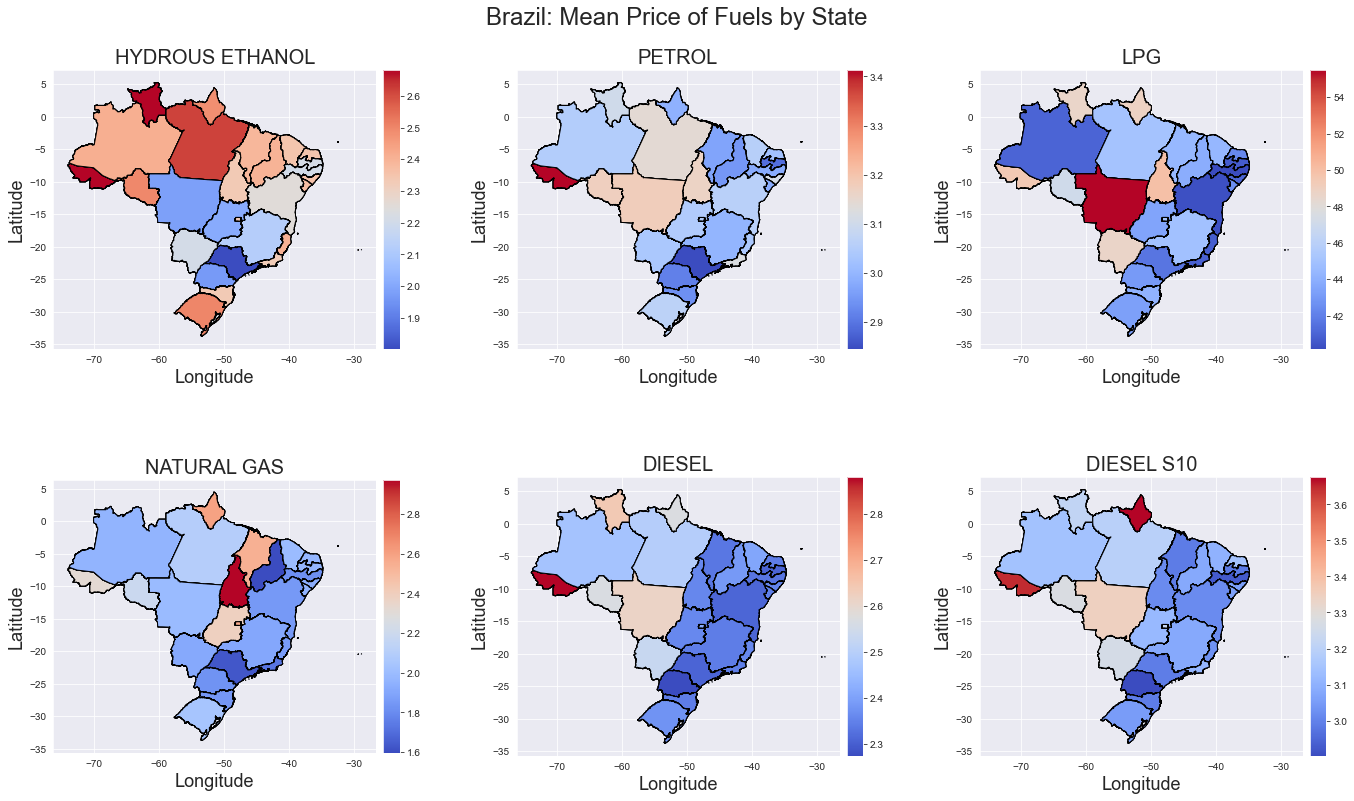

In [14]:
# Create plot function with raw price data: choropleth_product(data, column, title, cmap)
nrows = 2
ncols = 3
products = df.Product.unique()

fig, ax = plt.subplots(figsize=(20,12), nrows=nrows, ncols=ncols)

# set counter
n = 0

# Iterate through figure axes
for row in range(nrows): # iterate through rows
   
    for col in range(ncols): # iterate through each column while on one row
        
        # Adjust location and size of legend
        divider = make_axes_locatable(ax[row,col]) 
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        # Plot choropleth
        brazil_fuel_state_geo[brazil_fuel_state_geo.Product==products[n]].plot(column="Fuel_Mean_Price", 
                                                                       cmap="coolwarm", 
                                                                       legend=True, ax=ax[row,col], 
                                                                       cax=cax, edgecolor='black')
        
        # Set title and labels
        ax[row,col].set_title(products[n], fontsize=20)
        ax[row,col].set_xlabel("Longitude", fontsize=18)
        ax[row,col].set_ylabel("Latitude", fontsize=18)
        
        n += 1

fig.suptitle("Brazil: Mean Price of Fuels by State", fontsize=24)
plt.tight_layout(pad=5)
plt.savefig(fig_path + 'choropleth_mean_fuel_price_state.png', bbox_inches='tight')
plt.show()

#### Choropleth: Most and Least Expensive Fuels by State

In [15]:
states = brazil_fuel_state.State.unique().tolist()

# Create dataframe of cheapest fuels by state
cheapest_fuels = pd.DataFrame()

# Iterate through group-by objects and extract minimum: extreme_of_group(data, column, extreme)
for i in range(len(states)):

    state_group = brazil_fuel_state_geo.groupby("State").get_group(states[i])
    state_group = state_group[state_group.Fuel_Mean_Price == state_group.Fuel_Mean_Price.min()]
    cheapest_fuels = cheapest_fuels.append(state_group)
    cheapest_fuels.rename({"Fuel_Mean_Price":"Fuel_Min_Price"}, inplace=True)
    
# Create dataframe of cheapest fuels by state
expensive_fuels = pd.DataFrame()

# Remove LPG from list of products
brazil_fuel_state_geo_noLPG = brazil_fuel_state_geo[brazil_fuel_state_geo.Product!="LPG"]

# Iterate through group-by objects and extract minimum: extreme_of_group(data, column, extreme)
for i in range(len(states)):

    state_group = brazil_fuel_state_geo_noLPG.groupby("State").get_group(states[i])
    state_group = state_group[state_group.Fuel_Mean_Price == state_group.Fuel_Mean_Price.max()]
    expensive_fuels = expensive_fuels.append(state_group)
    expensive_fuels.rename({"Fuel_Mean_Price":"Fuel_Max_Price"}, inplace=True)

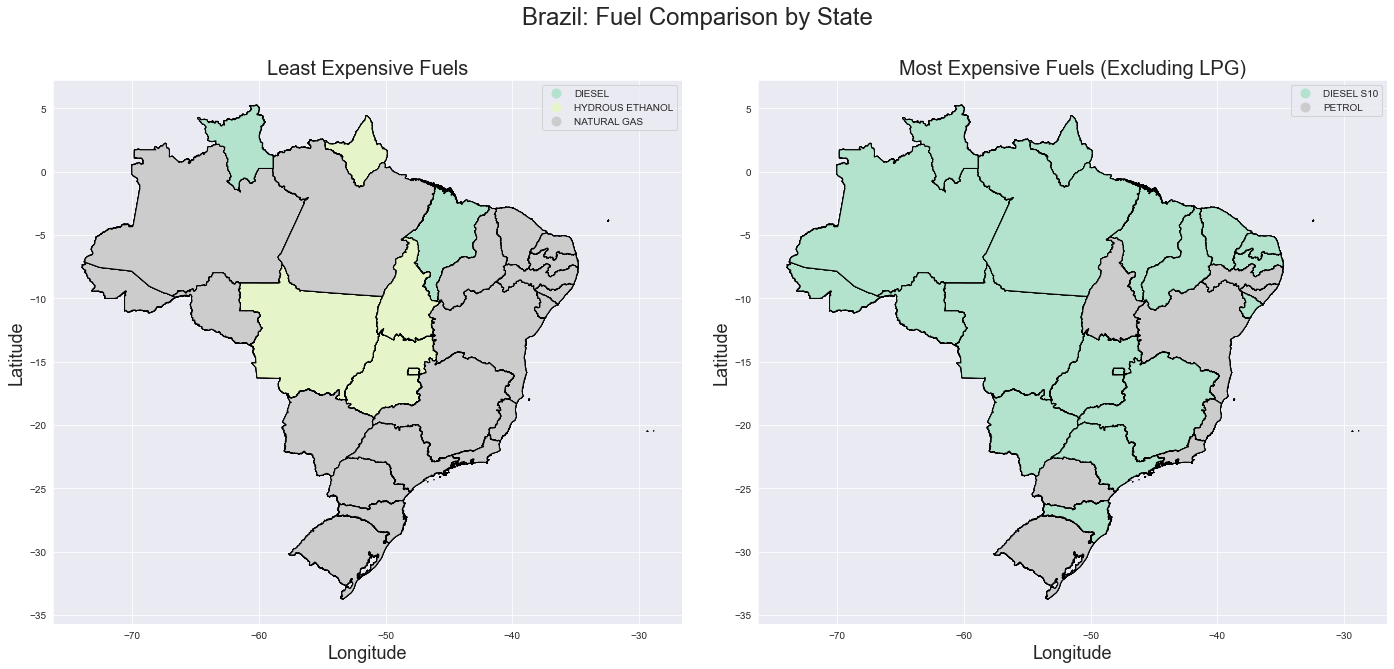

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Choropleths of cheapest and most expensive fuels
expensive_fuels.plot(column="Product", cmap="Pastel2", legend=True, ax=ax[1], edgecolor='black')
cheapest_fuels.plot(column="Product", cmap="Pastel2", legend=True, ax=ax[0], edgecolor='black')

# Format figure and axes
ax[0].set_title("Least Expensive Fuels", fontsize=20)
ax[1].set_title("Most Expensive Fuels (Excluding LPG)", fontsize=20)
ax[0].set_ylabel("Latitude", fontsize=18)
ax[0].set_xlabel("Longitude", fontsize=18)
ax[1].set_ylabel("Latitude", fontsize=18)
ax[1].set_xlabel("Longitude", fontsize=18)

plt.suptitle("Brazil: Fuel Comparison by State", fontsize=24)
plt.tight_layout(pad=3)
plt.savefig(fig_path + 'choropleth_fuel_comparison_by_state.png', bbox_inches='tight')
plt.show()